### Custom unitary gate approach

See documentation at https://qiskit.org/documentation/tutorials/simulators/4_custom_gate_noise.html 

In [13]:
from qiskit import transpile, QuantumCircuit
import qiskit.quantum_info as qi

from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, amplitude_damping_error

from qiskit.tools.visualization import plot_histogram


In [14]:
# Use Operator class in qiskit.quantum_info to represent arbitrary matrix operators
# Unitary operator can be added to quantum circuit simulation; here CNOT and iSWAP gate example

# CNOT matrix operator with qubit-0 as control and qubit-1 as target
cx_op = qi.Operator([[1, 0, 0, 0],
                     [0, 0, 0, 1],
                     [0, 0, 1, 0],
                     [0, 1, 0, 0]])

# iSWAP matrix operator
iswap_op = qi.Operator([[1, 0, 0, 0],
                        [0, 0, 1j, 0],
                        [0, 1j, 0, 0],
                        [0, 0, 0, 1]])

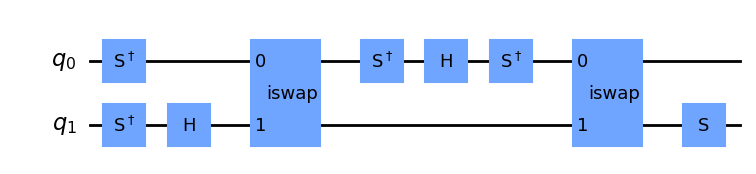

In [15]:
# CNOT in terms of iSWAP and single-qubit gates
cx_circ = QuantumCircuit(2, name='cx<iSWAP>')

# Add gates
cx_circ.sdg(1)    
cx_circ.h(1)
cx_circ.sdg(0)
cx_circ.unitary(iswap_op, [0, 1], label='iswap')
cx_circ.sdg(0)
cx_circ.h(0)
cx_circ.sdg(0)
cx_circ.unitary(iswap_op, [0, 1], label='iswap')
cx_circ.s(1)      # S gate is pi/2 rotation around Z axis

cx_circ.draw("mpl")    # alternatively, print(cx_circ)
print("Example of a CNOT gate decomposed using single-qubit and iSWAP gates")

In [16]:
# Simulate the unitary for the circuit using Operator:
unitary = qi.Operator(cx_circ)
print(unitary)
f_ave = qi.average_gate_fidelity(cx_op, unitary)
print("Average Gate Fidelity: F = {:f}".format(f_ave))

Operator([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
          [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
          [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))
Average Gate Fidelity: F = 1.000000


In [20]:
# AerSimulator can run arbitrary unitary operators specified by "unitary" in basis gates.
'unitary' in AerSimulator().configuration().basis_gates

True

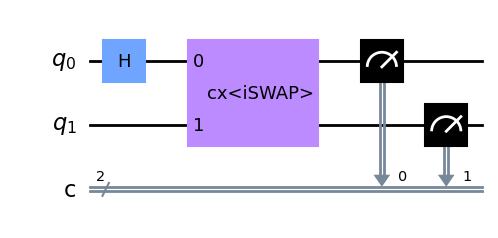

In [25]:
# Bell state circuit where iSWAPS should be inserted at barrier locations
bell_circ = QuantumCircuit(2, 2, name='bell')
bell_circ.h(0)
bell_circ.append(cx_circ, [0, 1])
bell_circ.measure([0,1], [0,1])

bell_circ.draw("mpl")    #print(bell_circ)

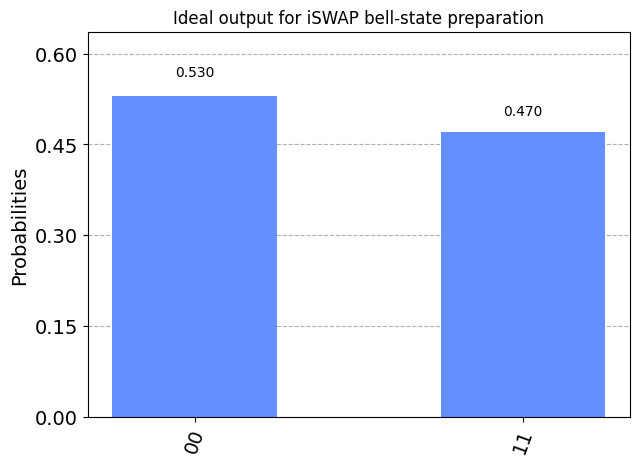

In [29]:
# Create ideal simulator backend and transpile circuit
sim_ideal = AerSimulator()
tbell_circ = transpile(bell_circ, sim_ideal)

ideal_result = sim_ideal.run(tbell_circ).result()
ideal_counts = ideal_result.get_counts(0)
plot_histogram(ideal_counts,
               title='Ideal output for iSWAP bell-state preparation')

### Propagator math

Any operator M can be decomposed into a Hermitian and anti-Hermitian component.

Definitions - Hermitian: $H^\dagger = H$ ; anti-Hermitian: $H^\dagger = -H$

$A = \frac{A + A^\dagger}{2} + \frac{A - A^\dagger}{2} = B + C$

Hermitian:
$B^\dagger = \frac{A^\dagger + A}{2} = B$

Anti-Hermitian:
$C^\dagger = \frac{A^\dagger - A}{2} = -C$

Propagator $U = 
\begin{pmatrix}
S_m & 0 & 0 & 0\\
0 & -S_p & 0 & 0\\
0 & 0 & -A_m & 0\\
0 & 0 & 0 & A_p
\end{pmatrix}
$

In [30]:
import qiskit.tools.jupyter
%qiskit_version_table